I try to implement this paper https://www.comp.nus.edu.sg/~gilbert/CS4234/2015/lectures/06.ATSP.pdf
and then see what I can do with it

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from icecream import ic
import networkx as nx
from sklearn.manifold import MDS

Usual functions

In [55]:
CITIES = [
    "Rome",
    "Milan",
    "Naples",
    "Turin",
    "Palermo",
    "Genoa",
    "Bologna",
    "Florence",
    "Bari",
    "Catania",
    "Venice",
    "Verona",
    "Messina",
    "Padua",
    "Trieste",
    "Taranto",
    "Brescia",
    "Prato",
    "Parma",
    "Modena",
]
distance_matrix_test = np.load('lab2/test_problem.npy')

def isMatrixSymmetric(matrix):
    return np.allclose(matrix, matrix.T)

def doesMatrixHaveZeroDiagonal(matrix):
    return np.allclose(matrix.diagonal(), 0.0)

def doesMatrixHaveNegativeValues(matrix):
    return np.any(matrix < 0)

def isTriangleInequalitySatisfied(matrix):
    n = matrix.shape[0]
    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            for k in range(n):
                if i == k or j == k:
                    continue
                if matrix[i, k] > matrix[i, j] + matrix[j, k]:
                    return False
    return True

def isValidSolution(solution_matrix):
    n = solution_matrix.shape[0]
    for i in range(n):
        if np.sum(solution_matrix[i, :]) != 1:
            return False
        if np.sum(solution_matrix[:, i]) != 1:
            return False
    if solution_matrix.trace() != 0:
        return False
    graph = nx.DiGraph(solution_matrix)
    cycles = list(nx.simple_cycles(graph))
    if len(cycles) != 1 and len(cycles[0]) != n:
        return False
    return True

def totalDistance(path, distance_matrix):
    total_distance = 0
    n = len(path)
    for i in range(n):
        j = (i + 1) % n
        total_distance += distance_matrix[path[i], path[j]]
    return total_distance

def generateRandomSolutionArray(num_cities):
    solution = list(range(num_cities))
    np.random.shuffle(solution)
    return solution

def generateGreadySolutionArray(distance_matrix, start_city=0):
    n = distance_matrix.shape[0]
    unvisited = set(range(n))
    current_city = start_city
    path = [current_city]
    unvisited.remove(current_city)
    while unvisited:
        list_available_cities_distances = [(distance_matrix[current_city][city], city) for city in unvisited]
        next_city = min(list_available_cities_distances, key=lambda x: x[0])[1]
        path.append(next_city)
        unvisited.remove(next_city)
        current_city = next_city
    return path

def generateUltraGreadySolutionArray(distance_matrix):
    n = distance_matrix.shape[0]
    path_len = float('inf')
    best_path = None
    for i in range(n):
        path = generateGreadySolutionArray(distance_matrix, start_city=i)
        current_path_len = totalDistance(path, distance_matrix)
        if current_path_len < path_len:
            path_len = current_path_len
            best_path = path
    return best_path

def distanceMatrixToCoordinates(D):
    n = D.shape[0]    # distance_matrix is n x n

    M = np.zeros_like(D)
    for i in range(n):
        for j in range(n):
            M[i, j] = 0.5 * (D[0, j]**2 + D[i, 0]**2 - D[i, j]**2)
    # Matrix decomposition
    eigenvalues, eigenvectors = np.linalg.eig(M)
    assert np.allclose(eigenvectors @ np.diag(eigenvalues) @ eigenvectors.T, M)

    X = eigenvectors @ np.diag(np.sqrt(np.abs(eigenvalues)))
    
    # Indices where eigenvalues are too small (considered as zero or negative)
    small_eigenvalue_indices = np.where(np.abs(eigenvalues) < 1e-10)[0]
    X = np.delete(X, small_eigenvalue_indices, axis=1)
    
    return X

# Only works when the distance matrix is symmetric
def reduceDimensionality(coordinates, target_dim=2):
    mds = MDS(n_components=target_dim, dissimilarity='euclidean', random_state=42)
    reduced_coordinates = mds.fit_transform(coordinates)
    return reduced_coordinates

def plotCities2D(coordinates_2D, city_names = None, title = ""):
    plt.figure(figsize=(6, 4))
    plt.scatter(coordinates_2D[:, 0], coordinates_2D[:, 1], color='blue')
    
    num_cities = coordinates_2D.shape[0]
    
    if city_names is not None:
        assert len(city_names) == num_cities, "Number of city names must match number of cities."
        for i, city in enumerate(city_names):
            plt.text(coordinates_2D[i, 0], coordinates_2D[i, 1], city, fontsize=9, ha='right')
    
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    
def plotPath2D(coordinates_2D, path, city_names = None, title = ""):
    n = len(path)
    plotCities2D(coordinates_2D, city_names, title)
    for i in range(n):
        start_city = path[i]
        end_city = path[(i + 1) % n]
        plt.plot(
            [coordinates_2D[start_city, 0], coordinates_2D[end_city, 0]],
            [coordinates_2D[start_city, 1], coordinates_2D[end_city, 1]],
            color='blue'
        )
        
def reduceAndPlotPath(distance_matrix, path, city_names = None, title = ""):
    n = distance_matrix.shape[0]
    coordinates = distanceMatrixToCoordinates(distance_matrix)
    reduced_coordinates = reduceDimensionality(coordinates, target_dim=2)
    plotPath2D(reduced_coordinates, path, city_names, title)
    
def plotPathMatrix2D(coordinates_2D, path_matrix, city_names = None, title = ""):
    n = path_matrix.shape[0]
    plotCities2D(coordinates_2D, city_names, title)
    for i in range(n):
        for j in range(n):
            if path_matrix[i, j] == 1:
                plt.plot(
                    [coordinates_2D[i, 0], coordinates_2D[j, 0]],
                    [coordinates_2D[i, 1], coordinates_2D[j, 1]],
                    color='blue'
                )
def reduceAndPlotPathMatrix(distance_matrix, path_matrix, city_names = None, title = ""):
    n = distance_matrix.shape[0]
    coordinates = distanceMatrixToCoordinates(distance_matrix)
    reduced_coordinates = reduceDimensionality(coordinates, target_dim=2)
    plotPathMatrix2D(reduced_coordinates, path_matrix, city_names, title)

paper

In [46]:
from scipy.optimize import linprog

In [47]:
# Try to solve a relaxed version of the TSP using linear programming
# where we try to find disjoint paths that cover all cities

# This is AI generated
def solve_relaxed_atsp(distance_matrix):
    n = distance_matrix.shape[0]
        
    # Create the cost vector (flattened distance matrix excluding diagonal)
    c = []
    edge_to_index = {}
    index = 0
        
    for i in range(n):
        for j in range(n):
            if i != j:  # Exclude diagonal elements
                c.append(distance_matrix[i, j])
                edge_to_index[(i, j)] = index
                index += 1
        
    # Create constraint matrices
    # Each row corresponds to one constraint
    # We need 2*n constraints: n for outgoing edges, n for incoming edges
        
    num_variables = n * (n - 1)  # Total number of edges (excluding self-loops)
    A_eq = np.zeros((2 * n, num_variables))
    b_eq = np.ones(2 * n)
        
    # Outgoing edge constraints: for each vertex u, sum of xu,v = 1
    for u in range(n):
        constraint_row = u
        for v in range(n):
            if u != v:
                edge_index = edge_to_index[(u, v)]
                A_eq[constraint_row, edge_index] = 1
        
    # Incoming edge constraints: for each vertex u, sum of xv,u = 1
    for u in range(n):
        constraint_row = n + u
        for v in range(n):
            if v != u:
                edge_index = edge_to_index[(v, u)]
                A_eq[constraint_row, edge_index] = 1
        
    # Bounds: all variables >= 0 (and <= 1 for LP relaxation)
    bounds = [(0, 1) for _ in range(num_variables)]
        
    # Solve the linear program
    result = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds)
        
    return result, edge_to_index

In [48]:
s, e = solve_relaxed_atsp(distance_matrix_test)

In [49]:
s

        message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
        success: True
         status: 0
            fun: 1967.1500000000003
              x: [ 0.000e+00  1.000e+00 ...  0.000e+00  1.000e+00]
            nit: 37
          lower:  residual: [ 0.000e+00  1.000e+00 ...  0.000e+00
                              1.000e+00]
                 marginals: [ 2.826e+02  0.000e+00 ...  5.244e+01
                              0.000e+00]
          upper:  residual: [ 1.000e+00  0.000e+00 ...  1.000e+00
                              0.000e+00]
                 marginals: [ 0.000e+00  0.000e+00 ...  0.000e+00
                              0.000e+00]
          eqlin:  residual: [ 0.000e+00  0.000e+00 ...  0.000e+00
                              0.000e+00]
                 marginals: [ 1.884e+02  1.003e+02 ... -0.000e+00
                             -5.007e+01]
        ineqlin:  residual: []
                 marginals: []
 mip_node_count: 0
 mip_dual_bound: 0.0
        mip

In [50]:
s.x

array([ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,
        0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
       -0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0

In [51]:
e

{(0, 1): 0,
 (0, 2): 1,
 (0, 3): 2,
 (0, 4): 3,
 (0, 5): 4,
 (0, 6): 5,
 (0, 7): 6,
 (0, 8): 7,
 (0, 9): 8,
 (0, 10): 9,
 (0, 11): 10,
 (0, 12): 11,
 (0, 13): 12,
 (0, 14): 13,
 (0, 15): 14,
 (0, 16): 15,
 (0, 17): 16,
 (0, 18): 17,
 (0, 19): 18,
 (1, 0): 19,
 (1, 2): 20,
 (1, 3): 21,
 (1, 4): 22,
 (1, 5): 23,
 (1, 6): 24,
 (1, 7): 25,
 (1, 8): 26,
 (1, 9): 27,
 (1, 10): 28,
 (1, 11): 29,
 (1, 12): 30,
 (1, 13): 31,
 (1, 14): 32,
 (1, 15): 33,
 (1, 16): 34,
 (1, 17): 35,
 (1, 18): 36,
 (1, 19): 37,
 (2, 0): 38,
 (2, 1): 39,
 (2, 3): 40,
 (2, 4): 41,
 (2, 5): 42,
 (2, 6): 43,
 (2, 7): 44,
 (2, 8): 45,
 (2, 9): 46,
 (2, 10): 47,
 (2, 11): 48,
 (2, 12): 49,
 (2, 13): 50,
 (2, 14): 51,
 (2, 15): 52,
 (2, 16): 53,
 (2, 17): 54,
 (2, 18): 55,
 (2, 19): 56,
 (3, 0): 57,
 (3, 1): 58,
 (3, 2): 59,
 (3, 4): 60,
 (3, 5): 61,
 (3, 6): 62,
 (3, 7): 63,
 (3, 8): 64,
 (3, 9): 65,
 (3, 10): 66,
 (3, 11): 67,
 (3, 12): 68,
 (3, 13): 69,
 (3, 14): 70,
 (3, 15): 71,
 (3, 16): 72,
 (3, 17): 73,
 (3, 18): 

In [52]:
def convertResultToSolution(result, edge_to_index, num_cities, threshold=0.5):
    solution_matrix = np.zeros((num_cities, num_cities))
    for (i, j), index in edge_to_index.items():
        if result.x[index] >= threshold:
            solution_matrix[i, j] = 1
    return solution_matrix

In [53]:
path = convertResultToSolution(s, e, distance_matrix_test.shape[0])

/home/niccolo/Torino/env/lib/python3.13/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


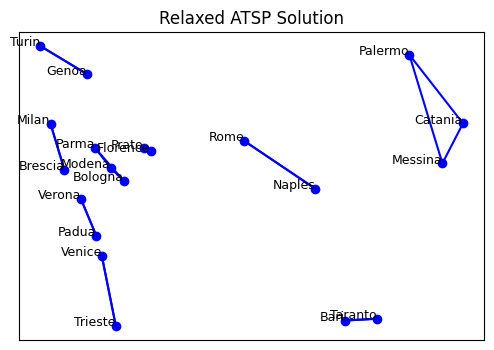

In [56]:
reduceAndPlotPathMatrix(distance_matrix_test, path, city_names=CITIES, title="Relaxed ATSP Solution")

We have an optimal solution for the relaxed version of the problem.

Now from paper 1.4 approximation algorithm

In [ ]:
def pasteCycles(D, cycles):
    point_to_cycle = {}
    for cycle_idx, cycle in enumerate(cycles):
        for node in cycle:
            point_to_cycle[node] = cycle_idx
    
    # 1. Start with j = 1 and at node x = x1 in cycle D.
    result_cycle = []
    k = len(cycles)
    x = D[0]
    
    # 2. Repeat k times:
    for i in range(k):
        j = point_to_cycle[x]
        cycle_j = cycles[j]
        
        for offset in range(len(cycle_j)):
            node = cycle_j[(x_pos + offset) % len(cycle_j)]
            result_cycle.append(node)
        
        y = D[(i + 1) % k]
        
        x = y
    
    # 3. Short-cut all the repeated nodes in the newly constructed cycle
    seen = set()
    final_cycle = []
    for node in result_cycle:
        if node not in seen:
            final_cycle.append(node)
            seen.add(node)
    
    return final_cycle
        

def recursive_algorithm(distance_matrix):
    # 1. Find a cycle cover C1, C2, . . . , Ck.
    s, e = solve_relaxed_atsp(distance_matrix)
    
    # 2. Choose one point xj ∈ Cj from each cycle. This yields k points x1, x2, . . . , xk. Notice that k ≤ n/2 (since each cycle is of length ≥ 2).
    selected_points = []
    path_matrix = convertResultToSolution(s, e, distance_matrix.shape[0], threshold=0.9)
    graph = nx.DiGraph(path_matrix)
    cycles = list(nx.simple_cycles(graph))
    for cycle in cycles:
        selected_points.append(cycle[0])  # Choose the first point of each cycle
    
    # 3. If k = 1, return the cycle C1
    if len(cycles) == 1:
        return cycles[0]
    
    # 4. If k > 1, recursively calculate the asynchronous-TSP cycle of points (x1, x2, . . . , xk). Let D be the cycle returned.
    reduced_matrix = distance_matrix[np.ix_(selected_points, selected_points)]
    D_indices = recursive_algorithm(reduced_matrix)
    
    # Map D_indices (indices in reduced matrix 0, 1, ..., k-1) to actual node IDs
    # D_indices contains indices into the reduced matrix, so we map them to selected_points
    D = [selected_points[i] for i in D_indices]
    
    # 5. Paste together the cycle D with the cycles C1, C2, . . . , Ck and return that new cycle.
    final_cycle = pasteCycles(D, cycles)
    return final_cycle    

In [72]:
cycle = recursive_algorithm(distance_matrix_test)

/home/niccolo/Torino/env/lib/python3.13/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


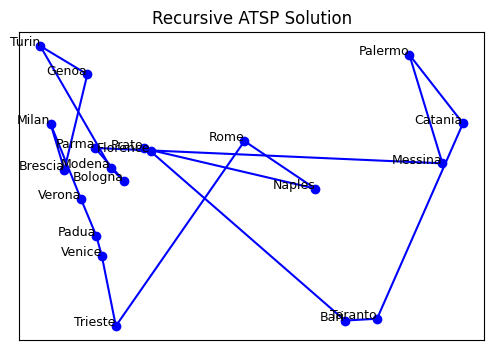

In [73]:
reduceAndPlotPath(distance_matrix_test, cycle, city_names=CITIES, title="Recursive ATSP Solution")